In [30]:
%load_ext autoreload
%autoreload 2 

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal as mvn
from hetgpy import homGP, hetGP
import pandas as pd
import yaml
from typing import Dict
import json
from collections import Counter, defaultdict

from helpers import *

from eqsql import worker_pool, db_tools, cfg
from eqsql.task_queues import local_queue

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)

In [33]:
exp_id = 1
# start database
#db_tools.stop_db(params['db_path'])
db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
db_started = True

# start local task queue
task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                            port=None, db_name=params['db_name'])

# check if the input and output queues are empty,
# if not, then exit with a warning.
if not task_queue.are_queues_empty():
    print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
    task_queue.clear_queues()

Checking for pg_ctl ...
/Users/abbystevens/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/Users/abbystevens/Documents/db/emews_db/db.log
Database server started


In [34]:
# set up grid
xx = np.linspace(0, 1, 30)
Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))

# generate some seeds
seeds = np.random.choice(100, 20, replace=False)

# budget
budget = 50
nts = 10 #number of new points per thompson sample

# initialize 
init_ids = [217, 233, 465, 697, 713]
init_reps = 3
init_ids = {x:init_reps for x in init_ids}
budget -= len(init_ids)*init_reps

init_seeds = seeds[:init_reps]
id_counter = Counter()

X, Xnative = generate_inputs(Xgrid, init_ids, id_counter, seeds)

In [ ]:
# start worker pool
pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                    exp_id, pool_params)
task_type = params['task_type']

# run initial simulations
payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])


In [36]:
# normalizing Y for numerical stability
Y = np.log(Y)
ymean, ystd = Y.mean(), Y.std()
Y = (Y-ymean)/ystd

Homoskedastic model has higher log-likelihood: 
 -8.538128329331037  compared to  -8.74260293898028 

Return homoskedastic model 



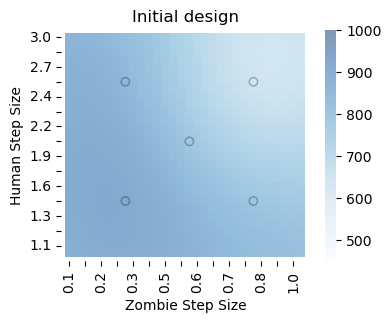

In [37]:
gp = hetGP()
gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), init={'g_bounds':[1e-6, .1]})

plot_gp_mean(gp, Xgrid, X, ymean, ystd, title='Initial design')

In [49]:
import time
t0 = time.time()
best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
print(time.time() - t0)


1.186366081237793


In [48]:
best_ids

Counter({0: 1,
         15: 1,
         330: 1,
         217: 1,
         104: 1,
         4: 1,
         29: 1,
         210: 1,
         75: 1,
         11: 1})

In [27]:
i = 1
while budget > 0:
    # thompson sample for best locations
    #best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
    #budget -= nts
    
    # get new runs and combine
    Xnew_native = []
    Xnew = []
    for ix, cnt in best_ids.items():
        start = id_counter[ix]
        end = id_counter[ix] + cnt
        Xt, Xt_native = generate_inputs(Xgrid, best_ids, id_counter, seeds)
        Xnew.append(Xt)
        Xnew_native.append(Xt_native)
    Xnew = np.vstack(Xnew)
    Xnew_native = np.vstack(Xnew_native)
    payloads = list(map(lambda a: json.dumps(list(a)), Xnew_native))
    _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
    sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
    Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
    # scale outputs
    Ynew = np.log(Ynew)
    Ynew = (Ynew - ymean)/ystd

    X = np.vstack([X, Xnew])
    Y = np.concatenate([Y, Ynew])

    Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
    Ynative = Ynative = np.exp(Y*ystd + ymean)
    best_ix = np.argmax(Ynative)
    print(f"After iteration {i}, we found that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
    gp = hetGP()
    gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), 
           init={'g_bounds':[1e-6, .1]}, maxit=1000)
    plot_gp_mean(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')
    i += 1


KeyboardInterrupt: 

After iteration 1, we found that 965 humans can survive at zombie_step_size = 0.26, human_step_size = 1.0


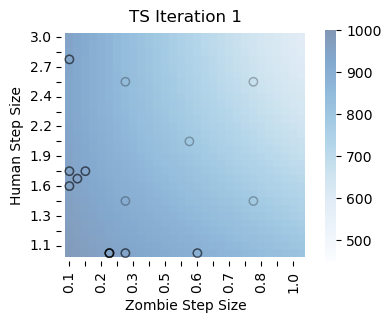

In [20]:
Ynew = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
# scale outputs
Ynew = np.log(Ynew)
Ynew = (Ynew - ymean)/ystd

X = np.vstack([X, Xnew])
Y = np.concatenate([Y, Ynew])

Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
Ynative = Ynative = np.exp(Y*ystd + ymean)
best_ix = np.argmax(Ynative)
print(f"After iteration {i}, we found that {round(Ynative[best_ix])} humans can survive at zombie_step_size = {round(Xnative[best_ix, 0],2)}, human_step_size = {Xnative[best_ix, 1]}")
gp = hetGP()
gp.mle(X, Y, covtype='Matern5_2', upper=np.array([100, 100]), 
        init={'g_bounds':[1e-6, .1]}, maxit=1000)
plot_gp_mean(gp, Xgrid, X, ymean, ystd, title=f'TS Iteration {i}')

In [84]:
n_points = 10
best_ids = Counter(TS_npoints(model = gp, npoints = n_points, Xgrid = Xgrid))
#X_new = Xgrid[best_ids]

In [37]:
for ix, cnt in best_ids.items():
    break

In [43]:
Xs = []
for ix, cnt in best_ids.items():
    start = id_counter[ix]
    end = id_counter[ix] + cnt
    for s in seeds[start:end]:
        Xs.append(np.append(Xgrid[ix], s))

In [54]:
X = np.vstack(Xs)

In [62]:
X[:, -1:]

array([[594.],
       [594.],
       [594.],
       [594.],
       [594.],
       [594.],
       [594.],
       [594.],
       [594.],
       [594.]])

array([[1.31034483e-01, 1.75862069e+00, 5.94000000e+02],
       [4.72413793e-01, 1.00000000e+00, 5.94000000e+02],
       [1.00000000e-01, 1.00000000e+00, 5.94000000e+02],
       [1.00000000e-01, 2.31034483e+00, 5.94000000e+02],
       [1.00000000e-01, 2.24137931e+00, 5.94000000e+02],
       [1.00000000e-01, 2.17241379e+00, 5.94000000e+02],
       [4.10344828e-01, 1.00000000e+00, 5.94000000e+02],
       [5.65517241e-01, 1.00000000e+00, 5.94000000e+02],
       [1.00000000e-01, 1.82758621e+00, 5.94000000e+02],
       [3.48275862e-01, 1.00000000e+00, 5.94000000e+02]])

In [33]:
Xnew = []
Xnew_native = []
for ix, cnt in best_ids.items():
    start = id_counter[ix]
    end = id_counter[ix] + cnt
    Xt, Xtn = generate_inputs(Xgrid[ix], seeds[start:end])
    Xnew.append(Xt)
    Xnew_native.append(Xtn)

IndexError: tuple index out of range

In [34]:
Xgrid[ix]

array([0.03448276, 0.37931034])

In [ ]:
# run initial simulations
payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
_, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])
# normalizing Y for numerical stability
Y_scaled, (ymean, ystd) = scale_y(Y)

In [15]:
i = 1
while budget > 0:
    # thompson sample for best locations
    best_ids = Counter(TS_npoints(model = gp, npoints = n_points, Xgrid = Xgrid))
    budget -= n_points
    
    # get new runs and combine
    Xnew = []
    for ix, cnt in best_ids.items():
        start = id_counter[ix]
        end = id_counter[ix] + cnt
        Xt, Xtn = generate_inputs(Xgrid[[ix]], seeds[start:end])
        Xnew.append(Xt)
    Xnew = np.vstack(Xnew)
    Ynew = np.log(np.concatenate(Ynew))

    X = np.vstack([X, Xnew])
    Y = np.concatenate([Y, Ynew])

    Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
    gp = homGP()
    gp.mle(X, Y)

    plot_gp_mean(gp, Xgrid, Xgrid_native, Xnative, Y, title=f"Iteration {i}")
    i += 1


Counter({330: 2, 14: 1, 10: 1, 15: 1, 161: 1, 43: 1, 150: 1, 7: 1, 0: 1})

In [9]:
def initial_samples(n=5, grid_size=30, init_id=[]):
    xx = np.linspace(0, 1, grid_size)
    Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
    if len(init_id)==0:
        N = Xgrid.shape[0]
        init_id = np.random.choice(N, n, replace=False)
        
    return (Xgrid[init_id], Xgrid)


def to_native(x, lb, ub):
    x_native = np.empty_like(x)
    for i in range(x.shape[1]): 
        x_native[:, i] = lb[i] + x[:, i] * (ub[i] - lb[i])
    return x_native


def TS_npoints(model, npoints, Xgrid, inflate_factor=2):
        
    #' Batch Bayesian optimization using Thompson sampling
    #'
    #' @param model an object of class `hetGP`; e.g., as returned by `mleHetGP`
    #' @param npoints an integer representing the desired number of samples
    #' @param Xgrid a matrix of locations at which the samples are drawn
    #'
    #' @return a matrix containing the `npoints` best locations where next batch of simulations should be run

    pred_mean, pred_cov = model.predict(Xgrid, full_cov=True)
    cov_mtx = 0.5 * (pred_cov + pred_cov.T)
    tTS = mvn.rvs(mean=pred_mean.reshape(-1), cov=cov_mtx, size=npoints * 2)
    best_ids = list(set(np.argmax(tTS, axis=1)))[:npoints]
    return Xgrid[best_ids]


def plot_gp_mean(gp, Xgrid, Xgrid_native, X_native, Y, logged=True, outfile=None, title=None):
    fig, ax = plt.subplots(1,1, figsize = (4, 3))
    
    df = pd.DataFrame(Xgrid_native, columns=['zombie_step_size', 'human_step_size'])
    #df[['zombie_step_size', 'human_step_size']] = df[['zombie_step_size', 'human_step_size']].round(2)
    pred_mean, pred_var = gp.predict(Xgrid)
    
    if logged:
        df['surface'] = np.exp(pred_mean)
    else:
        df['surface'] = pred_mean
            
    # Create the heatmaps
    surface_pivot = df.pivot(index='human_step_size', columns='zombie_step_size', values='surface').sort_index(ascending=False)
    
    surface_pivot.index = surface_pivot.index.round(3)
    surface_pivot.columns = surface_pivot.columns.round(3)
    X_native = X_native.round(3)
    
    # Transform scatter point coordinates to match heatmap's grid
    # Mapping the real 'human_step_size' and 'zombie_step_size' to the heatmap's row and column indices
    human_indices = pd.Series(X_native[:, 1]).map({value: idx for idx, value in enumerate(surface_pivot.index)})
    zombie_indices = pd.Series(X_native[:, 0]).map({value: idx for idx, value in enumerate(surface_pivot.columns)})
    
    surface_pivot.index = surface_pivot.index.round(1)
    surface_pivot.columns = surface_pivot.columns.round(1)
    
    sns.heatmap(surface_pivot, ax=ax, cmap='Blues', vmin=100, vmax=3900)
        # Set limits with a small margin
    # add smaller buffer
    margin_size = .5  # Adjust margin size as needed
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim([xlim[0] - margin_size, xlim[1] + margin_size])
    ax.set_ylim([ylim[0] + margin_size, ylim[1] - margin_size])
    
    xlabels = [label if i % 2 == 0 else '' for i, label in enumerate(ax.get_xticklabels())]
    ax.set_xticklabels(xlabels)
    
    # For y-axis
    ylabels = [label if i % 2 == 0 else '' for i, label in enumerate(ax.get_yticklabels())]
    ax.set_yticklabels(ylabels)
    
    ax.set_xlabel('Zombie Step Size')
    ax.set_ylabel('Human Step Size')
    if title is not None:
        plt.title(title)
    
    # Plot scatter points with adjusted coordinates
    ax.scatter(zombie_indices+.5, human_indices+.5, edgecolors='black', c=np.exp(Y), cmap='Blues', vmin=100, vmax=3900)
    
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def run(exp_id: str, params: Dict):

    db_started = False
    pool = None
    task_queue = None

    try:
        """
        EMEWS setup
        """
        # start database
        db_tools.start_db(params['db_path'], pg_bin_path=params['pg_bin_path'])
        db_started = True

        # start local task queue
        task_queue = local_queue.init_task_queue(params['db_host'], params['db_user'],
                                                    port=None, db_name=params['db_name'])

        # check if the input and output queues are empty,
        # if not, then exit with a warning.
        if not task_queue.are_queues_empty():
            print("WARNING: db input / output queues are not empty. Aborting run", flush=True)
            task_queue.clear_queues()
            return

        # start worker pool
        pool_params = worker_pool.cfg_file_to_dict(params['pool_cfg_file'])
        pool = worker_pool.start_local_pool(params['worker_pool_id'], params['pool_launch_script'],
                                            exp_id, pool_params)
        task_type = params['task_type']

        # set up grid
        xx = np.linspace(0, 1, 30)
        Xgrid = np.array(np.meshgrid(xx, xx)).T.reshape(-1, 2)
        Xgrid_native = to_native(Xgrid, lb=np.array([0.1, 1]), ub=np.array([1, 3]))

        # initialize 
        init_ids = [217, 233, 465, 697, 713]
        X = Xgrid[init_ids]
        Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        
        # run initial simulations
        payloads = list(map(lambda a: json.dumps(list(a)), Xnative))
        _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)

        sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
        Y = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

        # logging response for numerical stability
        Y = np.log(Y)

        # keep track of best 
        f_best = []
        X_best = np.empty((0, 2))

        f_best.append(np.exp(np.max(Y)))
        X_best = np.vstack([X_best, X[np.argmax(Y)]])
        
        native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
        print(f">> iter = 0: current best value = {f_best[0]} at zombie_step_size = {native_best[0, 0]}, human_step_size = {native_best[0, 1]}")

        # fit GP on logged response
        gp = homGP()
        gp.mle(X, Y)

        # plot initial fit/design
        plot_gp_mean(gp, Xgrid, Xgrid_native, Xnative, Y, title='Initial design')

        n_steps = params['n_steps']
        n_points = params['n_points']

        for i in np.arange(1, n_steps + 1):
            best_ids = Counter(TS_npoints_replicates(gp, min(nts,budget), Xgrid))
            
            X_new = TS_npoints(model = gp, npoints = n_points, Xgrid = Xgrid)
            X_new_native = to_native(X_new, lb= np.array([0.1, 1]), ub=np.array([1, 3]))
            payloads = list(map(lambda a: json.dumps(list(a)), X_new_native))
            _, fts = task_queue.submit_tasks(exp_id, task_type, payloads)
            sorted_fts = sorted(task_queue.as_completed(fts), key=lambda ft: ft.eq_task_id)
            Y_new = np.array([json.loads(ft.result()[1]) for ft in sorted_fts])

            # log for numerical stability
            Y_new = np.log(Y_new)
            
            # append to existing best
            X = np.vstack([gp.X, X_new])
            Xnative = to_native(X, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
            Y = np.vstack([gp.Y, Y_new.reshape(-1,1)])

            # update GP with new data
            #gp.set_XY(X, Y)
            gp = GPy.models.GPRegression(X, Y)
            gp.optimize()

            best_ix = np.argmax(Y)
            f_best.append(np.exp(Y[best_ix][0]))
            X_best = np.vstack([X_best, X[best_ix]])

            plot_gp_mean(gp, Xgrid, Xgrid_native, Xnative, Y, title=f'TS iteration {i}')
            
            native_best = to_native(X_best, lb=np.array([0.1, 1]), ub=np.array([1, 3]))
            print(f">> iter = {i}: current best value = {f_best[i]} at zombie_step_size = {native_best[i, 0]}, human_step_size = {native_best[i, 1]}")

        # # Plot sequential trajectory
        # clist = ['red']*n1 + ['navy']*(X.shape[0]-n1)
        # alist = [1]*n1 + list(np.linspace(.1, 1, X.shape[0]-n1))
                            
        # plt.scatter(X[:,0], X[:,1], alpha=alist, c=clist)
        # plt.show()

        return (X, Y)
                    

    finally:
        if task_queue is not None:
            task_queue.close()
        if pool is not None:
            pool.cancel()
        if db_started:
            db_tools.stop_db(params['db_path'])

In [ ]:
if task_queue is not None:
    task_queue.close()
if pool is not None:
    pool.cancel()
if db_started:
    db_tools.stop_db(params['db_path'])

Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Starting database with log:/home/nick/Documents/db/wsc_tutorial/db.log
Database server started
>> iter = 0: current best value = 2210.1999999999994 at zombie_step_size = 0.3172413793103448, human_step_size = 1.4827586206896552


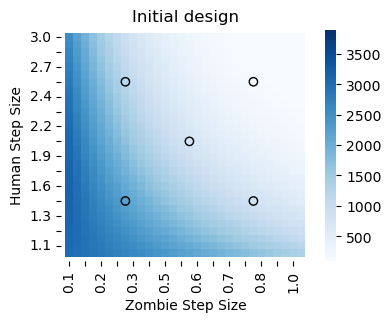

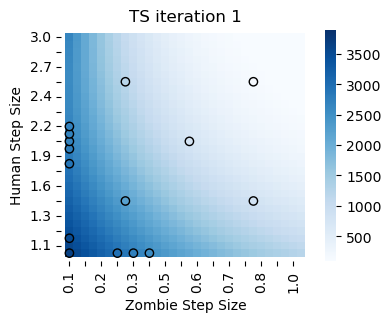

>> iter = 1: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


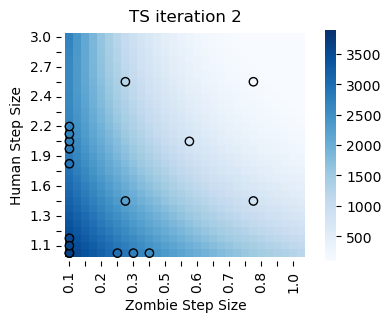

>> iter = 2: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


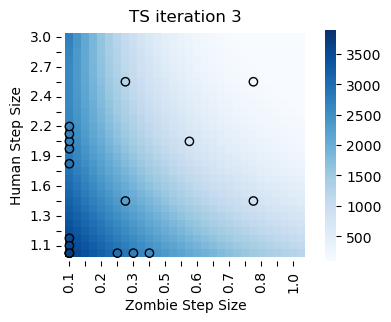

>> iter = 3: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0


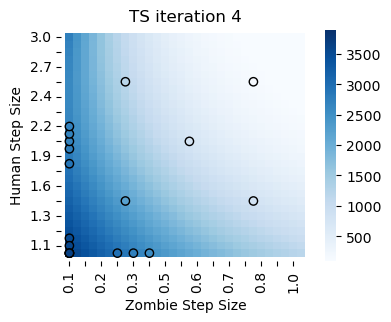

>> iter = 4: current best value = 3656.3999999999983 at zombie_step_size = 0.1, human_step_size = 1.0
Checking for pg_ctl ...
/home/nick/miniconda3/envs/emews-py3.10/bin/pg_ctl


Stopping database server

waiting for server to shut down.... done
server stopped



In [12]:
from eqsql import cfg
config_file = "./algo_cfg.yaml"
params = cfg.parse_yaml_cfg(config_file)
X, Y = run('t1', params)